In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('health_data.csv')
data.head()

,age,restbps,chol,category
0,26,109,243,0
1,27,106,156,0
2,28,107,225,0
3,27,105,277,0
4,30,96,221,0


In [3]:
#first, lets try a bayes classifier with the class conditional densities assumed to be Gaussian. There are two categories, 0 and 1.
X = data.to_numpy()[:, :3]
Y = data.to_numpy()[:, 3]


split = 0.8 #using 70:30 split, random each time
train_samples = np.random.choice(X.shape[0], int(split*X.shape[0]))
test_samples = np.array([i for i in range(X.shape[0]) if i not in list(train_samples)])

X_train = X[[train_samples]]
Y_train = Y[[train_samples]]

X_test = X[[test_samples]]
Y_test = Y[[test_samples]]


X_0 = X_train[Y_train == 0]
X_1 = X_train[Y_train == 1]

#X_0 = data[data['category'] == 0].to_numpy()[:, :3]
#X_1 = data[data['category'] == 1].to_numpy()[:, :3]
#how to split data into test and train?


C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the f

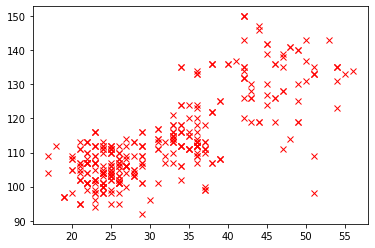

In [4]:
plt.plot(X_0[:,0], X_0[:,1], 'rx') #cholestrol vs age
#clearly they are not independent features

In [5]:
#estimating mean, variance for class 0
#maximum likelihood estimate

u0 = np.mean(X_0, axis=0) 
s0 = (X_0 - u0).T @ (X_0 - u0)/X_0.shape[0]
s0 = np.linalg.inv(s0)

#for class 1
u1 = np.mean(X_1, axis = 0)
s1 = (X_1 - u1).T @ (X_1 - u1)/X_1.shape[0]
s1 = np.linalg.inv(s1) #inverse of cov matrix

In [6]:
#decision boundary
p0 = X_0.shape[0]; p1 = X_1.shape[0]
p0 = p0/(p0 + p1); p1 = 1 - p0;
print('p0 = {}, p1 = {}'.format(p0, p1))
#priors chosen on basis of frequency of occurence in training data.
p = np.log(p0/p1)

s = 0.5*np.log(np.linalg.det(s0)/np.linalg.det(s1))
def g1(x):
    y = p + s -0.5*((x - u0) @ s0 @ (x-u0).T - (x - u1) @ s1 @ (x - u1))
    
    if (y > 0): 
        return 0
    else:return 1

p0 = 0.6035714285714285, p1 = 0.39642857142857146


In [7]:
#computing accuracy.
C = np.zeros((2,2)) #[[]]
for i in range((X_test.shape[0])):
    y_pred = g1(X_test[i])
    C[y_pred, Y_test[i]] += 1
        

In [8]:
acc = (C[0,0] + C[1,1])/np.sum(C)
print(acc)
# nearly 85 % accuracy obtained, in almost every case, no matter how the data is split.

0.8446601941747572


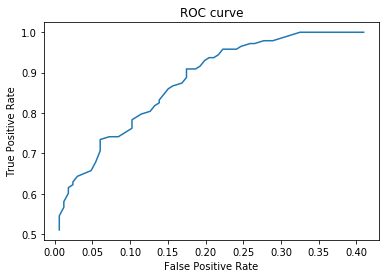

In [17]:
#Now, we will vary the priors, and plot the ROC curve.
TP = []
FP = []
for p0 in np.linspace(0.01,0.99,100):
    p = np.log(p0/(1 - p0))
    def g2(x):
        y = p + s -0.5*((x - u0) @ s0 @ (x-u0).T - (x - u1) @ s1 @ (x - u1))
    
        if (y > 0): 
            return 0
        else:return 1
    C = np.zeros((2,2))
    for i in range((X_test.shape[0])):
        y_pred = g2(X_test[i])
        C[y_pred, Y_test[i]] += 1
    
    tpr = C[1,1]/(C[1,1] + C[0,1])
    fpr = C[1,0]/(C[1,0] + C[0,0])
    TP.append(tpr)
    FP.append(fpr)

plt.plot(FP, TP, '-')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC curve');

# Gaussian mixture model
#kaafi complex.
#we have set of parameters, u_k, s_k, and pi_k.
'''
import math

def Gauss(x, u, s):
    d = x.shape[0]
    
    a = np.exp(-0.5*(x-u) @ np.linalg.inv(s) @ (x-u).T)
    S = np.abs(np.linalg.det(s))**(-0.5)
    
    return ((2*math.pi)**(-d/2))*S*a

#setting the number of components
K = 2
D = X.shape[1]
U = np.random.rand(K, D) #means

#guess for U
U = np.array([[35,110, 200],[60, 140, 250]])
S = np.random.rand(K, D, D)*50 #variances

print(U)
print(S)
P = np.random.rand(K); P = np.exp(P); P = P/sum(P); #pi's
N = X_train.shape[0]
G = np.zeros((N,K))

print(P)
def gamma(n, k):
    sum = 0;
    for j in range(K):
        sum += P[j]*Gauss(X_train[n], U[j, :], S[j, :, :]);
        #print('sum = ', sum);
    return P[k]*Gauss(X_train[n], U[k, :], S[k, :, :])/sum;

l_old = -1
thresh = 1e-3
iterations = 0


while(True):
    #E_step
    print('iter = {}, l = {}'.format(iterations, l_old))
    for i in range(N):
        for j in range(K):
            G[i, j] = gamma(i, j)
    
    #M step
    N_k = np.sum(G, axis = 0)
    #print('G.T:{}, X:{}, N_k:{}'.format(G.T.shape, X_train.shape, N_k.shape))
    U = (G.T @ X_train)/(N_k[:, np.newaxis])
    for k in range(K): #improve by using broadcasting!
        #print((X_train - U[k,:]).shape)
        #print(G[:, k].shape)
        S[k, :] = ((X_train - U[k, :]).T @ (G[:,k][:,np.newaxis]*(X_train - U[k, :])))/N_k[k]
    P = N_k/N
    
    #computing likelihood
    l = 0
    for i in range(N):
        s = 0
        for j in range(K):
            s += P[j]*Gauss(X_train[i], U[j, :], S[j, :, :])
            #print(s)
        l += np.log(s)
    #input()
    if np.abs(l - l_old) < thresh and iterations != 0:
        break;
    iterations += 1
    l_old = l
print('Done.')
#EM complete!!
'''

In [10]:
import math

def Gauss(x, u, s):
    d = x.shape[0]

    a = np.exp(-0.5*(x-u) @ np.linalg.inv(s) @ (x-u).T)
    S = np.abs(np.linalg.det(s))**(-0.5)

    return ((2*math.pi)**(-d/2))*S*a

def GMM(X, K):
    #Gaussian mixture model
    #X:data, K:number of components

    #gaussian evaluated at a particular point.


    #setting the number of components
    
    D = X.shape[1]
    N = X.shape[0]
    U = X[np.random.choice(N, K)] #initializing means as some K points in the data
    
    cov = np.cov(X, rowvar=False)
    
    #S = np.random.rand(K, D, D)*50 #variances
    S = np.stack([cov for k in range(K)], axis=0) #setting cov matrix of the data as guess for S
    
    P = np.random.rand(K); P = np.exp(P); P = P/sum(P); #pi's, the contribution of each component
    
    G = np.zeros((N,K))

    def gamma(n, k):
        sum = 0;
        for j in range(K):
            sum += P[j]*Gauss(X[n], U[j, :], S[j, :, :]);
            #print('sum = ', sum);
        return P[k]*Gauss(X[n], U[k, :], S[k, :, :])/sum;

    l_old = -1
    thresh = 1e-3
    iterations = 0
    loss_hist = []

    while(True):
        #E_step
        #print('iter = {}, l = {}'.format(iterations, l_old))
        for i in range(N):
            for j in range(K):
                G[i, j] = gamma(i, j)

        #M step
        N_k = np.sum(G, axis = 0)
        #print('G.T:{}, X:{}, N_k:{}'.format(G.T.shape, X_train.shape, N_k.shape))
        U = (G.T @ X)/(N_k[:, np.newaxis])
        for k in range(K): #improve by using broadcasting!
            #print((X_train - U[k,:]).shape)
            #print(G[:, k].shape)
            S[k, :] = ((X - U[k, :]).T @ (G[:,k][:,np.newaxis]*(X - U[k, :])))/N_k[k]
        P = N_k/N

        #computing likelihood
        l = 0
        for i in range(N):
            s = 0
            for j in range(K):
                s += P[j]*Gauss(X[i], U[j, :], S[j, :, :])
                #print(s)
            l += np.log(s)
        #input()
        loss_hist.append(l)
        if np.abs(l - l_old) < thresh and iterations != 0:
            break;
        iterations += 1
        l_old = l
    print('Done.')
    return P, U, S, loss_hist

#function to evaluate p(x) given parameters of GMM
def calc_p_gmm(x, a):
    #x: input point, a:parameters, returned from function GMM
    P = a[0]
    U = a[1]
    S = a[2]
    K = P.shape[0]
    sum = 0
    for k in range(K):
        sum += P[k]*Gauss(x, U[k, :], S[k, :, :])
    return sum

Done.
Done.


Text(0.5, 1.0, 'EM for class 0')

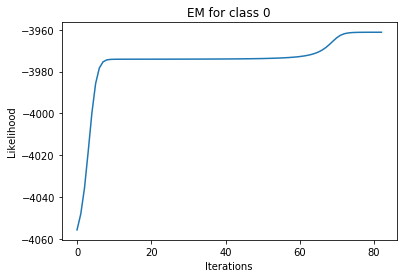

In [11]:
a0 = GMM(X_0, 2)
a1 = GMM(X_1, 2)
plt.plot(a0[3]);
plt.xlabel('Iterations'); plt.ylabel('Likelihood');
plt.title('EM for class 0')

Text(0.5, 1.0, 'EM for class 1')

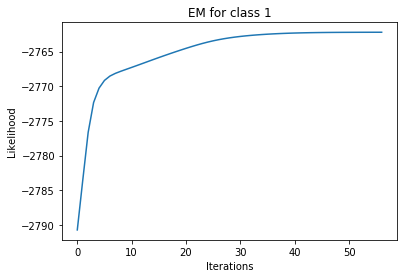

In [12]:
plt.plot(a1[3])
plt.xlabel('Iterations'); plt.ylabel('Likelihood');
plt.title('EM for class 1')

In [13]:
#building the bayes classifier for this GMM.
#how to choose priors?

def g3(x, a0, a1, p0):
    #a0, a1: parameters from EM for GMM. p0: prior probabilities
    if(p0*calc_p_gmm(x, a0) > (1-p0)*calc_p_gmm(x, a1)):
        return 0
    else:
        return 1

#calculating accuracy on the test set.
C = np.zeros((2,2)) #[[]]
for i in range((X_test.shape[0])):
    y_pred = g3(X_test[i], a0, a1, 0.5)
    C[y_pred, Y_test[i]] += 1
acc = (C[0,0] + C[1,1])/np.sum(C)
print(acc)

#84 percent accuracy acheived. Almost Same as previous case. Maybe varying priors will give better results.

#How to visualize these GMMs ??

0.8478964401294499


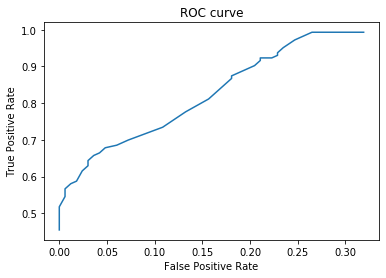

In [16]:
#plotting ROC curve.
TP = []
FP = []
for p0 in np.linspace(0.01,0.99,50):

    C = np.zeros((2,2))
    for i in range((X_test.shape[0])):
        y_pred = g3(X_test[i], a0, a1, p0)
        C[y_pred, Y_test[i]] += 1
    
    tpr = C[1,1]/(C[1,1] + C[0,1])
    fpr = C[1,0]/(C[1,0] + C[0,0])
    TP.append(tpr)
    FP.append(fpr)

plt.plot(FP, TP, '-')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC curve');

In [ ]:
#visualizing bias-variance trade off? Increasing model capacity(k) and then 